<h1><center>Aircraft Classification</center></h1>

In [0]:
# To install Talos, remove the following comments and execute the code:

#!pip install -U talos

In [0]:
# To delete the extracted and sorted directories and files from previous runs, if you please, remove the following comments and execute the code

#!rm -r ./extract
#!rm -r ./data

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold 

import seaborn as sns                                      
import time
import collections
import math
import os
import pandas as pd
import random
import sys
from six.moves import urllib
import io
import itertools
import shutil

from IPython.display import clear_output, Image, display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

import keras
from keras import layers
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import *
from keras.callbacks import *                                                   
from keras import regularizers
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.utils import to_categorical

from keras.activations import relu, elu, sigmoid
from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import mse, categorical_crossentropy

import talos as ta                                                              # Talos
from talos import Deploy

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1. Analysis of the Problem

Typically, in military contexts, it is important to be able to identify the aerial assets of friend or foe. All you might possibly have at your disposal are images, such as photos you have taken. These can then help in better identifying and classifying particular aircraft, using neural networks.
#### Categorisation
There are many types of aircraft that can be classified (categorised) in many ways. Even the smallest defense forces in world with air power can classify its aircraft according to the following types:<br>
- Trainer aircraft
- Transportation aircraft
- Helicopters
- Fighter Jets<br>

One could easily argue, however, that this categorisation is a bit too high-level to be useful. For example, transport aircraft could include anything from a Cessna Caravan, through to a Hercules C-130BZ, all the way to an airliner belonging to the VIP squadron. What the ideal neural network should be able to do is differentiate between different aircraft models, for example the Apache helicopter versus the Rooivalk helicopter. This would allow for situations where personnel can take pictures of aircraft at a distance, in order for the neural network to identify it. Even more ambitious than this would be to have a network that can differentiate between the same models of aircraft that have undergone some design baseline changes, such as adding weapons or EW equipment.
#### Data Availability and Homogeneity
Unfortunately, images of military aircraft are not always easily obtainable other than what can be downloaded from the internet or captured on camera, at air shows or under other circumstances. Thus, the model should be able to deal with relatively few images. These images, in terms of homogeneity do not necessarily have to be images of the aircraft in the air or on the ground; or do not necessarily have to be taken at the same time of day. This should be somewhat arbitrary in the end i.e. the model should not be distracted by 'background noise'. <br><br>

Perhaps, the best starting point would be to first create a neural network model that can identify aircraft and label them according to categories somewhere between these two extremes in terms of specificity, using a relatively small amount of data; and then from there develop it even further in future.

### 2. Aim of the Network<br>
The aim of this network, as a starting point to address the problem above, will be to focus on differentiating between fighter jets and airliners.

### 3. Input Data
Given the typical context of use of the proposed network model, images are not always easy to obtain and as such, to mimic this, input data will be limited. However, we will use data augmentation and other technques to attempt to compensate for this.<br><br>
Images were obtained from three sources: <br> 
South African Air Force photos from air shows and other demonstrations open to the public, obtained by me; <br>the Caltech 101 website [1]; and <br>from FreeStockImages.com [2] <br><br>
160 images were obtained and are split as follows: <br>
Thus for each class: <br>
There are 80 images. 80% of these will be for training and validation, 20% for final testing.


In [0]:
#Get the zip folder from drop box
!wget --no-check-certificate \
    https://www.dropbox.com/s/5etcsmw1yigjz2j/airliner_fighter_aircraft.zip?dl=0 \
    -O airliner_fighter_aircraft.zip
  
import os
import zipfile

#Unzip to the root directory
zip_filename = 'airliner_fighter_aircraft.zip'              # variable to store the file name
zip_ref = zipfile.ZipFile(zip_filename, 'r')                      

root_dir = "."
extract_dir = os.path.join(root_dir, 'extract')                                 # ./extract
zip_ref.extractall(extract_dir)                             # extracts all the pictures onto the root directory in the cloud

zip_ref.close()

--2019-03-04 13:26:38--  https://www.dropbox.com/s/5etcsmw1yigjz2j/airliner_fighter_aircraft.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5etcsmw1yigjz2j/airliner_fighter_aircraft.zip [following]
--2019-03-04 13:26:39--  https://www.dropbox.com/s/raw/5etcsmw1yigjz2j/airliner_fighter_aircraft.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5288288e7955b7c4de848535bf.dl.dropboxusercontent.com/cd/0/inline/AcdZyecABUwK3biWiDgA_gcqZlRoaH6xaCm1rv7ImuY7OFY_KQG3goJo7AqeYE4_n90zcKhLsvuytoYMeHMsS9gtz0S8AfhRMy3aF1pK7uv7uMtp-xWw_JB5FcwMdosmbJA/file# [following]
--2019-03-04 13:26:39--  https://uc5288288e7955b7c4de848535bf.dl.dropboxusercontent.com/cd/0/inline/AcdZyecABUwK3biWiDgA_gcqZlRoaH6xaCm1rv7ImuY7OFY_KQG3goJo7A

**Note**: The zip file imported contains two folders labeled 'airliner' and 'fighter'. The images have already been sorted and placed in these folders. This data will now be split for training (including validation) and testing.

In [0]:
from sklearn.model_selection import train_test_split

# LETS FIRST CREATE OUR ARRAYS OF DATA AND LABELS

# Read all images (.jpg) from a folder
# The function returns both the path of the aircraft image and the corresponding label ...
# ... which is defined by the name of the foler in which the image is
def read_images_from_dir(base_dir, folder):
    path_folder = os.path.join(base_dir, folder)
    files_directory = os.listdir(path_folder)    
    labels = []
    images = []
    for file in files_directory:
        if file.lower().endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images

def read_images(base_dir):
    labels = []
    images = []
    folders = os.listdir(base_dir)
    for folder in folders:      
      if not (folder == ".DS_Store"):          
          labels_folder, images_folder = read_images_from_dir(base_dir, folder)
          labels.extend(labels_folder)
          images.extend(images_folder)
    return labels, images

# this is the directory in which the image data has been extracted to ...       # ./extract/airliner_fighter_aircraft
image_dir = os.path.join(extract_dir,'airliner_fighter_aircraft')              

# ... and now we can assign our x and y:  
labels, images = read_images(image_dir)

# LETS NOW SPLIT OUT DATA IN TRAINING (INCL. VALIDATION) DATA AND TEST DATA AND CREATE FOLDER FOR THEM
test_fraction = 0.2        # this is the proportion of testing data, the rest is training data (and validation)
random_seed = 2019

# Split the data into training and test sets
# Note: Based on what we are putting in, we are getting out subsets in the form of lists (not arrays).
# We therefore cannot perform array operations on say images_train just yet...
# ... that will be possible after running this output data here through our ImageGenerators
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=test_fraction, random_state=random_seed, stratify=labels)

data_dir = os.path.join(root_dir,'data')                                        # ./data
if not os.path.exists(data_dir):                              
    os.mkdir(data_dir)

# Create folders for test and training that can be passed to Keras Generators ...
# ... and pass the files to them

def create_output_folders():
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    for label in set(labels):                
        if not os.path.exists(os.path.join(train_dir,label)):                    
          os.mkdir(os.path.join(train_dir,label))
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
    for label in set(labels):
        if not os.path.exists(os.path.join(test_dir, label)):        
          os.mkdir(os.path.join(test_dir, label))

def copy_files_to_train_and_test_folders():            
    for index, value in enumerate(images_train):
        dest = os.path.join(train_dir, labels_train[index])
        shutil.copy(value, dest)
       
    for index, value in enumerate(images_test):
        shutil.copy(value, os.path.join(test_dir, labels_test[index]))

train_dir = os.path.join(data_dir,'train')                                      # ./data/train
test_dir  = os.path.join(data_dir,'test')                                       # ./data/test
output_dir = os.path.join(data_dir,'output')                                    # ./data/output        
        
create_output_folders()
copy_files_to_train_and_test_folders()

# Manually creating the folders here
# Create folders for test and training specific to each label here   
train_airliner_dir = os.path.join(train_dir, 'airliner')                        # ./data/train/airliner
train_fighter_dir = os.path.join(train_dir, 'fighter')                          # ./data/train/fighter
test_airliner_dir  = os.path.join(test_dir, 'airliner')                         # ./data/test/airliner
test_fighter_dir = os.path.join(test_dir, 'fighter')                            # ./data/test/fighter

At this point the data has been imported. <br>
This is a good point to print them to screen to see how they will be put into the network.

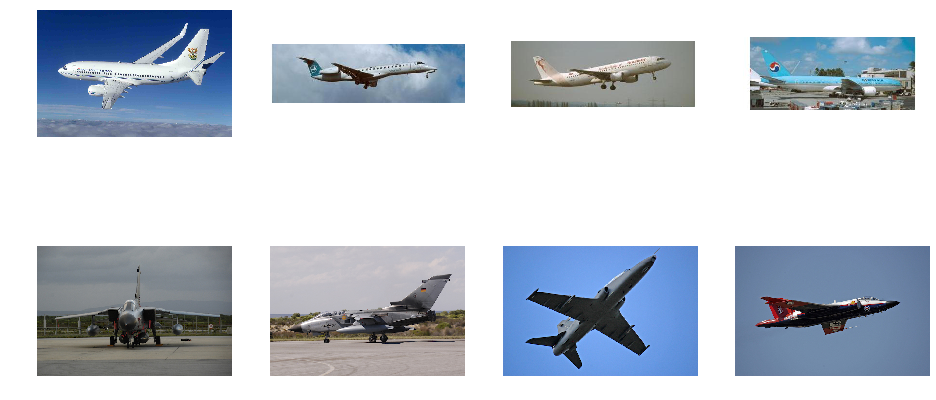

In [0]:
# sometimes img.show doesnt work unless you put this again:
%matplotlib inline  

nrows = 2
ncols = 4
# Index for iterating over images
pic_index = 0                                               # will be 0,1,2,3,4,5,6,7
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()                                             # get a reference to the current figure
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 4

train_airliner_fnames = os.listdir(train_airliner_dir)      # os.listdir returns files in a directory: Puts it in this array
#train_tfan_fnames.sort()
train_fighter_fnames = os.listdir(train_fighter_dir)        # os.listdir returns files in a directory: Puts it in this array
#train_fighter_fnames.sort()

# this creates an array with the directory and filename (fname) for each file in directory of cats training data
next_airliner_pix = [os.path.join(train_airliner_dir, fname) for fname in train_airliner_fnames[pic_index-4:pic_index]] # only the first eight though

next_fighter_pix = [os.path.join(train_fighter_dir, fname) for fname in train_fighter_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_airliner_pix + next_fighter_pix):
    
  # Set up subplot; subplot indices start at 1
  sp_intro = plt.subplot(nrows, ncols, i + 1)
  sp_intro.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)        # assigning the actual .jpeg file to the variable img
  plt.imshow(img)

plt.show()

In [0]:
num_airliner_images_train = len(os.listdir(train_airliner_dir))
num_fighter_images_train = len(os.listdir(train_fighter_dir))
num_airliner_images_test = len(os.listdir(test_airliner_dir))
num_fighter_images_test = len(os.listdir(test_fighter_dir))

print('Total airliner training images:', num_airliner_images_train)
print('Total fighter training images:', num_fighter_images_train)
print('Total airliner test images:', num_airliner_images_test)
print('Total fighter test images:', num_fighter_images_test)

Total airliner training images: 64
Total fighter training images: 64
Total airliner test images: 16
Total fighter test images: 16


**Note:** In the dataset, many images depict the aircraft surrounded by blue sky. It is assumed that the less the noise in the background, the better the accuracy will be of our classifier. However, that will limit the applicability (generalisability) of the neural network as well. In order for it to predict well, images were included of the aircraft on the ground whilst parked, in-taxi or at take-off.

### 4. Model Architecture
We will now attempt to prepare a network(s) for training, validation and testing. To analyse the data and the process a bit more closely (instead of just treating the neural network as a black box) we will be using two networks: <br><br>
#### Simple Fully Connected Layer Model
We will attempt to do image classification with a simple Fully Connected Layer Network, which has the layers: *in-relu-relu-relu-out(softmax)*. The accuracy of this will be scrutinised, but assuming it could be better, another model will also be chosen. <br><br>
#### VGG19 Model
The VGG19 model is considered as one of the top ten pretrained models to use, and has illustrated to be particularly effective in classifying car models [3]. Therefore it seems only logical that the network can be repurposed to classify aircraft. Thus, the VGG19 model will be used for transfer learning. Some tweaks will be made to the model, but that will be discussed later. What is important to note for now, however, is that VGG models were trained on images sized 224x224 and as such, that is the resolution we will work with for our input throughout. 


However, before we start building the model(s), lets first do some final data preprocessing based on what we know, and exactly in which format we want it.

In [0]:
image_width = 224       # choosing a common width for the simple network and the VGG19 network
image_height = 224      # choosing a common height for the simple network and the VGG19 network
batchsize = 1           # this is to make sure we obtain all the images and don't group them into batches

#Lets create some x (data) and y (label) generators
# All images will be rescaled by diving them by 255. This is to get the colour normalised to a number between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen_batches = train_datagen.flow_from_directory(     
        train_dir,                # train_dir has already been set up as the [parent] directory for airliner and fighter training data
        target_size=(image_width, image_height),    # All images will be resized as such
        batch_size= batchsize,
        class_mode='categorical')                   

test_gen_batches = test_datagen.flow_from_directory( 
        test_dir,                 # train_dir has already been set up as the [parent] directory for airliner and fighter testing data
        target_size=(image_width, image_height),
        batch_size= batchsize,
        class_mode='categorical')

Found 128 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


**Note**: In the code above, since we are currently only working with two classes, we could easily have specified the *class_mode* property of the datagen batches as 'binary' in stead of 'categorical'. This would mean the output layer of our network would have to have only one neuron which is either 0 if it points to one class or 1 if it points to the other class, rounded to either side by a sigmoid activation.<br>
However, in order to make this design modular, so that new types of aircraft can easily be added in future, the approach was taken to make it 'categorical'. Now, the output layer has to have two neurons - one for each class - and as such the target variable will be a one-hot encoded. 

128
data of batch shape: (1, 224, 224, 3)
label of batch shape: (1, 2)
label of batch: [[1. 0.]]


Our Demo sample label: [1. 0.]


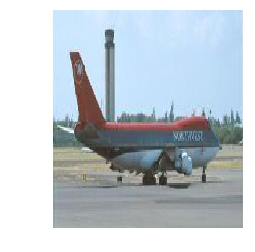

Training data array shape: (128, 224, 224, 3)
Training labels array shape: (128, 2)


In [0]:
## For training data:
# Create an empty array of the appropriate shape - for the training data
x_train = np.ones((train_gen_batches.samples, image_width, image_height, 3))
y_train = np.ones((train_gen_batches.samples, train_gen_batches.num_classes))

print(train_gen_batches.samples)

# Fill the array with the datagen batch's data and labels
i = 0
for data_of_batch, label_of_batch in train_gen_batches:
          
    #just for demonstration purposes, lets analyze the first sample (batch)
    if i == 0:                                                  
      print('data of batch shape:', data_of_batch.shape)
      print('label of batch shape:', label_of_batch.shape)
      print('label of batch:', label_of_batch)  
    
    x_train[i] = data_of_batch
    y_train[i] = label_of_batch
    
    i = i + 1
    
    if i == (train_gen_batches.samples):       # stop when we reached the last sample, otherwise this for loop continues indefinitely
      break

print("\n")      
print('Our Demo sample label:', y_train[0])
sp_array_demo = plt.subplot(1, 1, 1)
sp_array_demo.axis('Off')       
plt.imshow(x_train[0])
plt.show()

print('Training data array shape:', x_train.shape)
print('Training labels array shape:', y_train.shape)



Our Demo sample label: [0. 1.]


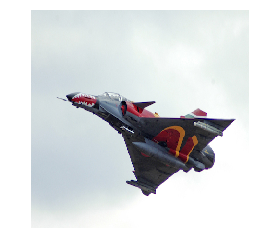

Testing data array shape: (32, 224, 224, 3)
Testing labels array shape: (32, 2)


In [0]:
## For testing data:
# Create an empty array of the appropriate shape - for the testing data
x_test = np.ones((test_gen_batches.samples, image_width, image_height, 3))
y_test = np.ones((test_gen_batches.samples, test_gen_batches.num_classes))

# Fill the array with the datagen batch's data and labels
i = 0
for data_of_batch, label_of_batch in test_gen_batches:  
    x_test[i] = data_of_batch
    y_test[i] = label_of_batch    
    i = i + 1
    if i == (test_gen_batches.samples - 1):     # stop when we reached the last sample, otherwise this for loop continues indefinitely
      break

print("\n")      
print('Our Demo sample label:', y_test[0])
sp_array_demo = plt.subplot(1, 1, 1)
sp_array_demo.axis('Off')       
plt.imshow(x_test[0])
plt.show()

print('Testing data array shape:', x_test.shape)
print('Testing labels array shape:', y_test.shape)

**Note:** What we can see here is that if the *class_mode* of the datagen batch is 'categorical', the labels indicate the class by using a **one-hot-encoding** methodology (i.e. the target variable is one-hot encoded). <br> What we will see below here is that [0,1] is the encoding for fighter and [1,0] is the encoding for airliner.

In [0]:
reverse = {v:k for k,v in train_gen_batches.class_indices.items()}
reverse

{0: 'airliner', 1: 'fighter'}

Data and labels of one batch of 10:



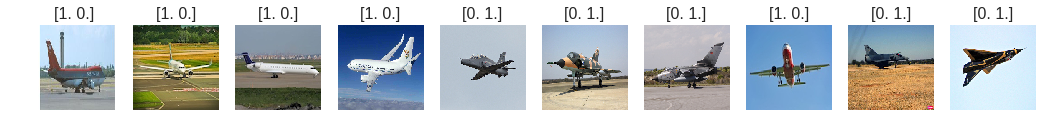

In [0]:
# plots images with labels
def plot_images_and_labels(ims, figsize, rows, cols, interp=False, titles=None):
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)                                   # this prints the one hot encoding label 
      #sp.set_title(reverse[titles[i][1]], fontsize=16)                      # this print the class based on the dictionary above - this wont work beyond two classes
      plt.imshow(ims[i], interpolation=None if interp else 'none')

# ----

print("Data and labels of one batch of 10:\n")
plot_images_and_labels(x_train[0:10], titles = y_train[0:10], rows = 1, cols = 10, figsize = (18,10))


Function *def plot_images_and_labels* adapted from function *def plots* courtesy of deeplizard [4].

#### Simple Fully Connected Layer Model

##### First Run
Lets now build our simple fully connected layer model:

In [0]:
model_simple = Sequential()

np.random.seed(0)
# Input - Layer
model_simple.add(Flatten(input_shape=(image_width,image_height,3)))
# Hidden - Layers
model_simple.add(Dense(32, activation='relu'))
model_simple.add(Dense(64, activation='relu'))
model_simple.add(Dense(64, activation='relu'))
# Output - Layer
model_simple.add(Dense(2, activation='softmax'))

model_simple.summary() 

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4816928   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 4,823,330
Trainable params: 4,823,330
Non-trainable params: 0
_________________________________________________________________


In [0]:
samples_fortraining = int(train_gen_batches.samples * 0.75)
samples_forvalidation = train_gen_batches.samples - samples_fortraining

x_train_fortraining = x_train[0:samples_fortraining]
y_train_fortraining = y_train[0:samples_fortraining]
x_train_forvalidation = x_train[samples_fortraining:]
y_train_forvalidation = y_train[samples_fortraining:]

model_simple.compile(loss= categorical_crossentropy,
                     optimizer= Adam(lr=1e-5, beta_1=0.9, beta_2=0.999), 
                     metrics=['acc'])

model_simple.fit(x_train_fortraining, 
                 y_train_fortraining,                           
                 batch_size= 5,                                        
                 epochs= 30,
                 verbose=0,
                 validation_data=(x_train_forvalidation, 
                                  y_train_forvalidation))           


Instructions for updating:
Use tf.cast instead.


Now lets plot the evaluated results

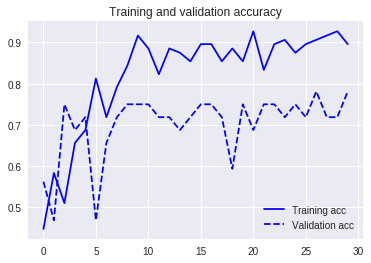

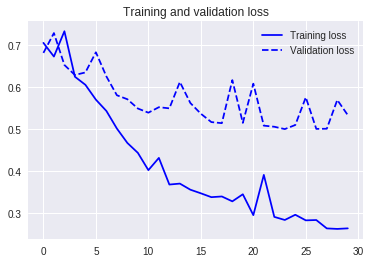

In [0]:
acc = model_simple.history.history['acc']
val_acc = model_simple.history.history['val_acc']
loss = model_simple.history.history['loss']
val_loss = model_simple.history.history['val_loss']

epochs = range(len(acc))    #this could have been range(len(loss)) etc.

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.title('Training and validation accuracy')
#plt.ylim((0.5,1))
plt.legend()

plt.figure() # plot the figure

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


The validation accuracy seems to lie between 70% and 80%. This fluctuation might be attributed to the fact that whilst data is assigned between training and test sets in the same propportion each time, the individual images that are assigned to those sets are random. One absolute remains: The training accuracy is ultimately more than the validation accuracy (acc>val_acc). This points towards overfitting, which might be the case if there is not enough data to fit and to generalise. <br>
For now lets first see how well our model is able to make **predictions**:

These are the images and ground truth labels:



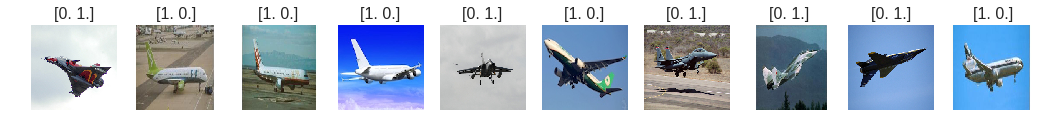

In [0]:
print("These are the images and ground truth labels:\n")
plot_images_and_labels(x_test[0:10], titles = y_test[0:10], rows = 1, cols = 10, figsize = (18,10))

In [0]:
y_pred = model_simple.predict(x_test, 
                              steps=1, 
                              verbose = 0)
print("These are the predicted labels for those images (unrounded):")
print(y_pred[0:10])

y_pred = ((y_pred > 0.5)*1)  #here we round the values of the prediction matrix to the closest 0 or 1
print("These are the predicted labels for those images (rounded):")
print(y_pred[0:10])

These are the predicted labels for those images (unrounded):
[[0.01816103 0.98183894]
 [0.8810235  0.11897653]
 [0.9648697  0.03513031]
 [0.9826514  0.01734858]
 [0.03609372 0.9639062 ]
 [0.22245343 0.7775466 ]
 [0.15364088 0.84635913]
 [0.8071365  0.19286357]
 [0.08744131 0.9125587 ]
 [0.77148116 0.22851878]]
These are the predicted labels for those images (rounded):
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]]


Looking at only the first 10 test images: The first matrix od rounded values above is a prediction of the labels shown above the images shown as output of the previous code cell. You can at times see from the matrix of unrounded values that even though it did choose the correct encoding at times, it is not always very confident about it. For example: <br>
[0.51, 0.49] points to an airliner [1, 0] but only just just got it right.

---



We will not see how well it predicted by looking at the accuracy and the level of **confusion**.

In [0]:
loss, acc = model_simple.evaluate(x_test, y_test, verbose=0)
print('The accuracy based on the test set is:', acc)

The accuracy based on the test set is: 0.75


The accuracy seems to be around 75% on the test data give or take 5%. This is definitely not ideal. Another way to look at this predictive ability of the network is to look at the confusion matrix:

Confusion matrix, without normalization
[[12  5]
 [ 3 12]]
Confusion matrix, without normalization
[[12  5]
 [ 3 12]]


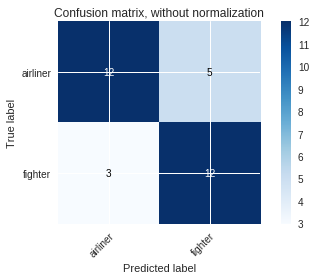

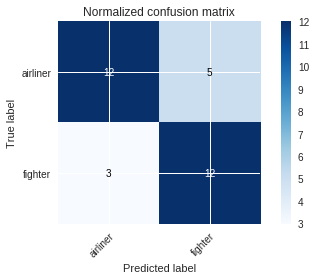

In [0]:
def plot_confusion_matrix(y_true, 
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# ----

class_names = {'fighter','airliner'}

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=class_names, title='Normalized confusion matrix')

## Note: we argmax here to return the index where the maximum is:
## The argmax of [1, 0] is position 0 which means for us it is an airliner
## The argmax of [0, 1] is position 1 which means for us it is a fighter jet

plt.show()

From this it seems that the network seems to confuse airliners as fighters or fighters as airliners a few times, making this mistake at most, on about a quarter of the test set images. That is still not good however. We need to reduce the confusion. There needs to be some regularisation introduced.

##### Second Run (with Regulatisation)

We will now try to see if we can improve the predictive capability of the simple model by performing some regularisation using three techniques:<br>
- Using **data augmentation** to add more data.
- Doing **batch normalisation**.
- Add an **dropout** layer in the network.
- Adding an early **stop**.

Note: The training data will be augmented. The test data, on the other hand, should not be - that would defeat the purpose of training our model on more data in order to be more predictive on the test data.

In [0]:
#Augmenting the data

batchsize = 1

augmentations_per_image = 4        

#Augmenting the data
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=30,
                  width_shift_range=0.1,
                  height_shift_range=0.2,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True)

train_gen_batches = train_datagen.flow_from_directory(     
        train_dir,                # train_dir has already been set up as the [parent] directory for turbofan and turbojet training data
        target_size=(image_width, image_height),    # All images will be resized as such
        batch_size= batchsize,
        class_mode='categorical') 

## For training data:
# Create an empty array of the appropriate shape - for the training data
# This shape is now large enough to also store the augmented data
new_length = train_gen_batches.samples * (augmentations_per_image + 1)
x_train = np.ones((new_length, image_width, image_height, 3))
y_train = np.ones((new_length, train_gen_batches.num_classes))
            
# Fill up our matrix with the necessary original and augmented images                  
i = 0
for data_of_batch, label_of_batch in train_gen_batches:         
    x_train[i] = data_of_batch
    y_train[i] = label_of_batch    
    i = i + 1    
    if i == new_length:           # stop when we reached the last sample, otherwise this for loop continues indefinitely
      break                  
index = i
                    

Found 128 images belonging to 2 classes.


Lets see what the array of images looks like, now that it includes augmented data:<br>
As you can see we are flipping horizontally, rotatings, shifting, zooming and shearing.

In [0]:
plot_images_and_labels(x_train, titles = y_train, rows = 64, cols = 10, figsize = (18,140))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Adding a dropout layer and batchnormalisation

model_simple_v2 = Sequential()

np.random.seed(0)
# Input - Layer
model_simple_v2.add(Flatten(input_shape=(image_width,image_height,3)))
# Hidden - Layers
model_simple_v2.add(BatchNormalization())
model_simple_v2.add(Dense(32, activation='relu'))
model_simple_v2.add(Dense(64, activation='relu'))
model_simple_v2.add(Dense(64, activation='relu'))
model_simple_v2.add(Dropout(0.5))
model_simple_v2.add(Dense(2))
# Output - Layer
model_simple_v2.add(Activation('softmax')) 

model_simple_v2.summary()    

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150528)            602112    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4816928   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
___________________________

In [0]:
#Split the data up again between training and testing data sets.
samples_fortraining = int(new_length * 0.75)
samples_forvalidation = new_length - samples_fortraining

x_train_fortraining = x_train[0:samples_fortraining]
y_train_fortraining = y_train[0:samples_fortraining]
x_train_forvalidation = x_train[samples_fortraining:]
y_train_forvalidation = y_train[samples_fortraining:]

model_simple_v2.compile(loss= categorical_crossentropy,
                     optimizer= Adam(lr=1e-5, beta_1=0.9, beta_2=0.999), 
                     metrics=['acc'])

# implementing the early stop
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8)

model_simple_v2.fit(x_train_fortraining, 
                    y_train_fortraining,                           
                    batch_size= 5,                                        
                    epochs= 50,
                    verbose=0,
                    callbacks = [early_stop],                         		          # implementing the early stop
                    validation_data=(x_train_forvalidation, 
                                     y_train_forvalidation))   

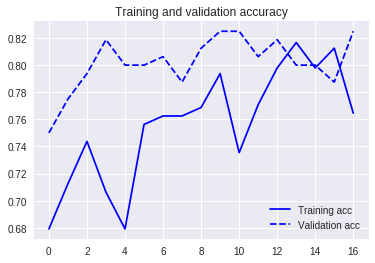

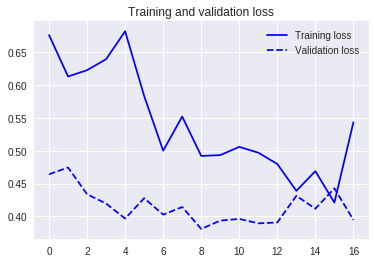

In [0]:
acc = model_simple_v2.history.history['acc']
val_acc = model_simple_v2.history.history['val_acc']
loss = model_simple_v2.history.history['loss']
val_loss = model_simple_v2.history.history['val_loss']

epochs = range(len(acc))    #this could have been range(len(loss)) etc.

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure() # plot the figure

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

It seems as though regularisation has decreased the overfitting. It improved the validation accuracy by about 5%, and the validation loss does not curve back up but continues decreasing.<br><br>

Conclusion:<br>
It seems as though the regularisation techniques helped: Data Augmentation, Batch Normalisation, Dropout and Early Stop. The validation accuracy is, however, not quite where we want it yet. <br> 
We will now move on to a pre-trained network; change the last few layers and then use the same regularisation techniques to make sure we are as predictive as possible.

#### VGG19 Model

We will now import the VGG19 model:

In [0]:
model_vgg19 = keras.applications.vgg19.VGG19() 
model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
type(model_vgg19)        # display the model type

keras.engine.training.Model

This is a functional model. We will need to convert it to a Sequential model.

In [0]:
# convert the pretrained network model to a sequential model
model_my_vgg19 = Sequential()
for layer in model_vgg19.layers[:-4]:
  model_my_vgg19.add(layer) 

In [0]:
model_my_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

Lets freeze all the remaining layers of the model and add our own.


In [0]:
# Lets freeze all the layers ...
for layer in model_my_vgg19.layers:
  layer.trainable = False

In [0]:
#... and then add our own  
model_my_vgg19.add(Flatten())
model_my_vgg19.add(Dense(500,use_bias=False))
model_my_vgg19.add(BatchNormalization())
model_my_vgg19.add(Activation('relu'))
model_my_vgg19.add(Dropout(0.5))     
model_my_vgg19.add(Dense(2)) 
model_my_vgg19.add(Activation('softmax')) 

model_my_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

So far, making changes and displaying the summary has only be for illustrative purposes. We are now going to attempt doing what we have done above (creating the model) whilst also training it with the regularisation and conducting **hyperparameter optimisation** with talos.

In [0]:
# TALOS DICTIONARY

p = {'dropout': [0.2, 0.5],
     'optimizer': ['sgd', 'adam', 'rmsprop'],
     'activation':[relu, elu]}

In [0]:
# CREATE THE MODEL:
# ------

def Airline_Fighter_Model(x_train_fortraining, y_train_fortraining, x_train_forvalidation, y_train_forvalidation, params):
    
  # creating the model
  model_vgg19 = keras.applications.vgg19.VGG19()
  model_my_vgg19 = Sequential()
  for layer in model_vgg19.layers[:-4]:
    model_my_vgg19.add(layer)
  for layer in model_my_vgg19.layers:
    layer.trainable = False
  model_my_vgg19.add(Flatten())
  model_my_vgg19.add(Dense(500,use_bias=False))
  model_my_vgg19.add(BatchNormalization())
  model_my_vgg19.add(Activation(params['activation']))
  model_my_vgg19.add(Dropout(params['dropout']))     
  model_my_vgg19.add(Dense(2)) 
  model_my_vgg19.add(Activation('softmax'))  
  
 
  model_my_vgg19.compile(loss=categorical_crossentropy,
                         optimizer=params['optimizer'],
                         metrics=['accuracy'])
  
  # regularisation: adding an early stop
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8)   
  
  # Remember: When it comes to model.fit: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])  
  # training the model
  # WE GET EPOCH (15) READINGS HERE FROM 'history' - 14 PER EPOCH
  history = model_my_vgg19.fit(x_train_fortraining, 
                               y_train_fortraining,                       
                               batch_size=5,
                               callbacks = [early_stop],                                         
                               epochs=30,
                               verbose=0,
                               validation_data=(x_train_forvalidation, 
                                                y_train_forvalidation))                           
  
  return history, model_my_vgg19

# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53  

In [0]:
t = ta.Scan(x = x_train,
            y = y_train,
            model=Airline_Fighter_Model,
            grid_downsample=1, 
            params=p,
            dataset_name='Airline_Fighter_Model',
            experiment_no='1')

100%|██████████| 12/12 [1:10:48<00:00, 400.01s/it]


In [0]:
print(p)
t.data

{'dropout': [0.2, 0.5], 'optimizer': ['sgd', 'adam', 'rmsprop'], 'activation': [<function relu at 0x7fe94e823510>, <function elu at 0x7fe94e8232f0>]}


,round_epochs,val_loss,val_acc,loss,acc,dropout,optimizer,activation
0,13,0.13026645197775602,0.9531250027939677,0.09875447241802249,0.9687500018626451,0.2,adam,<function relu at 0x7fe94e823510>
1,18,0.11975914211658771,0.9531250027939677,0.07120207335239163,0.9776785727590322,0.2,adam,<function elu at 0x7fe94e8232f0>
2,18,0.12672745246284953,0.9531250027939677,0.14880822574845556,0.9419642883419458,0.5,sgd,<function elu at 0x7fe94e8232f0>
3,30,0.08176250240889733,0.9635416688397527,0.07120416490331698,0.9776785727590322,0.5,rmsprop,<function relu at 0x7fe94e823510>
4,14,0.14431902200522018,0.9583333358168602,0.09847118134492965,0.9665178583070103,0.2,rmsprop,<function elu at 0x7fe94e8232f0>
5,27,0.10105395701369464,0.9531250027939677,0.03186356545255161,0.9843750009313226,0.2,sgd,<function elu at 0x7fe94e8232f0>
6,25,0.11686663455778519,0.9739583348855376,0.07482548871400597,0.9776785727590322,0.5,sgd,<function relu at 0x7fe94e823510>
7,18,0.12208816720279476,0.9531250027939677,0.10381779316529512,0.9665178588059332,0.5,adam,<function elu at 0x7fe94e8232f0>
8,19,0.13244701491688224,0.9427083367481828,0.06562239156820786,0.979910715483129,0.2,sgd,<function relu at 0x7fe94e823510>
9,25,0.10061095417275585,0.9583333358168602,0.12549398949115748,0.964285715549652,0.5,rmsprop,<function elu at 0x7fe94e8232f0>


For this it seems that our best hyperparameters to choose, the hyperparameters where the validation loss is the lowest, is:<br> 
- Optimizer: RMSProp<br>
- Activation: relu<br>
- Dropout rate: 0.2<br>

We will now use these hyperparameters to make our final model:

In [0]:
# creating the model
model_vgg19 = keras.applications.vgg19.VGG19()
model_my_vgg19_v2 = Sequential()
for layer in model_vgg19.layers[:-4]:
  model_my_vgg19_v2.add(layer)
for layer in model_my_vgg19_v2.layers:
  layer.trainable = False
model_my_vgg19_v2.add(Flatten())
model_my_vgg19_v2.add(Dense(500,use_bias=False))
model_my_vgg19_v2.add(BatchNormalization())
model_my_vgg19_v2.add(Activation('relu'))
model_my_vgg19_v2.add(Dropout(0.2))     
model_my_vgg19_v2.add(Dense(2)) 
model_my_vgg19_v2.add(Activation('softmax'))  
   

#Split the data up again between training and testing data sets.
samples_fortraining = int(new_length * 0.75)
samples_forvalidation = new_length - samples_fortraining

x_train_fortraining = x_train[0:samples_fortraining]
y_train_fortraining = y_train[0:samples_fortraining]
x_train_forvalidation = x_train[samples_fortraining:]
y_train_forvalidation = y_train[samples_fortraining:]

model_my_vgg19_v2.compile(loss= categorical_crossentropy,
                          optimizer= 'rmsprop', 
                          metrics=['acc'])

# implementing the early stop
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8)

model_my_vgg19_v2.fit(x_train_fortraining, 
                      y_train_fortraining,                           
                      batch_size= 5,                                        
                      epochs= 30,
                      verbose=0,
                      callbacks = [early_stop],                         		          # implementing the early stop
                      validation_data=(x_train_forvalidation, 
                                       y_train_forvalidation))

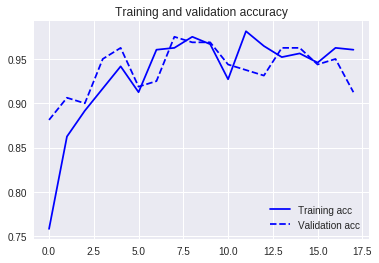

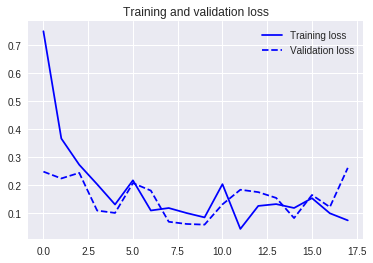

In [0]:
acc = model_my_vgg19_v2.history.history['acc']
val_acc = model_my_vgg19_v2.history.history['val_acc']
loss = model_my_vgg19_v2.history.history['loss']
val_loss = model_my_vgg19_v2.history.history['val_loss']

epochs = range(len(acc))    #this could have been range(len(loss)) etc.

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.title('Training and validation accuracy')
#plt.ylim((0.5,1))
plt.legend()

plt.figure() # plot the figure

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [0]:
loss, acc = model_my_vgg19_v2.evaluate(x_test, y_test, verbose=0)
print('The accuracy based on the test set is:', acc)

The accuracy based on the test set is: 0.90625


Confusion matrix, without normalization
[[16  1]
 [ 2 13]]
Confusion matrix, without normalization
[[16  1]
 [ 2 13]]


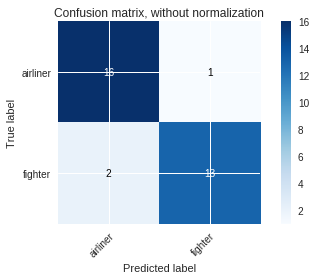

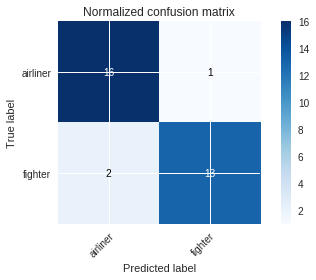

In [0]:
y_pred = model_my_vgg19_v2.predict(x_test, 
                              steps=1, 
                              verbose = 0)

class_names = {'fighter','airliner'}

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=class_names, title='Normalized confusion matrix')

## Note: we argmax here to return the index where the maximum is:
## The argmax of [1, 0] is position 0 which means for us it is an airliner
## The argmax of [0, 1] is position 1 which means for us it is a fighter jet

plt.show()

Looking at the accuracy and loss graphs, the predictive capability and the confusion matrix: <br>
Accuracy has improved tremendously. Confusion has also decreased.

### Conclusion
It is always best to obtain as much data as possible. If you have little data and a complicated network, chances are you will be overfitting. In some cases, however, data is not always available - as is the case with military aircraft photos. In those cases it is best to augment the data; pick a suitable pre-trained model where you freeze the layers except the final dense layers which you pop off and replace with your own; conduct more regularisation through batch normalisation, early stop, dropout and other techniques; conduct hyperparameter optimisation especially on the activation functions and optimizers; and finally train the model, monitoring the validation accuracy. After that you should be able to predict well using your test set.

### References

[1] Caltech, 2018. *Caltech101: Computational Vision*. [Online] 
Available at: http://www.vision.caltech.edu/Image_Datasets/Caltech101/
[Accessed 27 February 2018].<br>
[2] FreeStockImages, 2018 *FreeStockImages: Airplanes* [Online] Available at: https://www.stockfreeimages.com/ <br>
[3] Pranav, D., 2018. *Top 10 Pretrained Models*. [Online] 
Available at: https://www.analyticsvidhya.com/blog/2018/07/top-10-pretrained-models-get-started-deep-learning-part-1-computer-vision/
[Accessed 27 February 2018].<br>
[4] deeplizard, 2018. *Image Preparation for CNN Image Classifier with Keras*. [Online] 
Available at: https://automobilrevue.net/v/TGhFTVhiakdWXzQ
[Accessed 27 February 2018].
